# Citrination t-SNE API

In this tutorial, we're going to learn to use Citrination to generate a useful data analysis called t-SNE. This data visualization technique enables you to represent a high dimensional set of data in fewer dimensions in a way that preserves the local structure of the data. In materials informatics, this allows you to create a two-dimensional plot of a set of materials where points corresponding to similar materials are grouped together in two-dimensional space. More information on t-SNE here: https://lvdmaaten.github.io/tsne/

This tutorial will teach you to create and export a two-dimensional t-SNE plot for any data on Citrination. The first step is to create a data view on the Citrination: https://citrination.com/data_views. Instructions for creating a data view can be found in [this tutorial](https://github.com/CitrineInformatics/learn-citrination/blob/master/Journal%20Paper%20to%20Model%20Demo.ipynb).

We'll be using this data view: https://citrination.com/data_views/787 (view id 787) for this tutorial, which includes a model predicting experimental band gaps based on data compiled by W.H. Strehlow and E.L. Cook, which can be viewed in [this dataset](https://citrination.com/datasets/1160/show_search).

In [2]:
from citrination_client import CitrinationClient
import matplotlib.pyplot as plt
import os
import numpy as np

In [3]:
client = CitrinationClient(api_key=os.environ["CITRINATION_API_KEY"])
tsne = client.tsne("787")
print(tsne.keys())

[u'Color', u'Band gap']


The `tsne` call returns a dictionary where the top level keys correspond to the properties that are being modeled. In this data view, the model inputs are Chemical formula and Crystallinity. Citrine represents a chemical formula by calculating over 50 material descriptors. The t-SNE plot reduces that into just 2 dimensions. Let's look at the t-SNE plot for Band gap.

In [4]:
print(tsne["Band gap"].keys())

['y', 'x', 'z', 'uid', 'label']


- `x` is the x component of the t-SNE plot
- `y` is the y component of the t-SNE plot
- `z` is the property value (Band gap in this example)
- `uid` is the uid of the record on Citrination. You can find the record by going to https://citrination.com/pif/{uid}
- `label` is the list of the values of the model inputs for the record

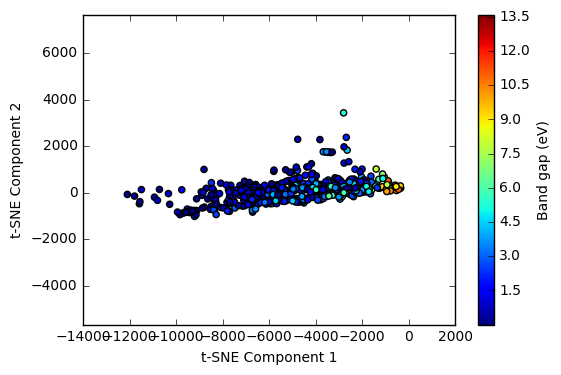

In [5]:
plt.scatter(tsne["Band gap"]['x'], tsne["Band gap"]['y'], c=tsne["Band gap"]['z'])
plt.colorbar(label="Band gap (eV)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.axes().set_aspect('equal', 'datalim')
plt.show()

When interpreting a t-SNE plot, keep in mind that the t-SNE components plotted on the x and y axes have no physical meaning. Since the t-SNE algorithm preserves the local structure of the data, we look at points that end up close together. Just from looking at the plot, we can see that there is a cluster of high bandgap materials that contains the material with the maximum band gap in the bottom right corner. Let's take a look at what those materials are.


(note: t-SNE is a non-deterministic algorithm, so the plot will change if the underlying Data View is retrained)

In [6]:
# Load the coordinates and band gap values into a numpy array
coordinates_and_bg = np.zeros((len(tsne["Band gap"]['x']), 3))
coordinates_and_bg[:,0] = tsne["Band gap"]["x"]
coordinates_and_bg[:,1] = tsne["Band gap"]["y"]
coordinates_and_bg[:,2] = tsne["Band gap"]["z"]

In [7]:
# Find the n materials closest to the target material, as specified by index
# based on cartesian distance in the t-SNE coordinates
def find_most_similar_materials(index, coordinates, n_materials=10):
    distances = np.linalg.norm(coordinates_and_bg[:,0:2] - coordinates_and_bg[index,0:2], axis=1)
    return np.argsort(distances)[1:n_materials+1]

From inspecting this cluster of materials, we can see that the t-SNE plot has grouped highly ionic materials together, and that these materials have very high band gaps.

Maximum band gap material:
Single crystalline, Li1F1, Band gap: 13.6, URL: https://citrination.com/pif/1160/2/2D201857DAC242016B215551856ECDC7
Similar materials:
Single crystalline, Li1Cl1, Band gap: 9.33, URL: https://citrination.com/pif/1160/2/EA3543704258945CD77DD23F356C58EB
Single crystalline, K1F1, Band gap: 10.9, URL: https://citrination.com/pif/1160/2/0AB11C1E53CAA3CF8C253F3DBAB086C3
Single crystalline, K1Cl1, Band gap: 8.5, URL: https://citrination.com/pif/1160/2/27AF4DA2B4398C4048C8D1F81282D90E
Single crystalline, Na1Cl1, Band gap: 8.97, URL: https://citrination.com/pif/1160/2/D9D68C946BE10E638821489AE12DE6B5
Na1F1, Band gap: 10.5, URL: https://citrination.com/pif/1160/2/AFEFAAA91C3CB1155E05CD9C979A3FA4
Single crystalline, Ca1F2, Band gap: 10.0, URL: https://citrination.com/pif/1160/2/EDF401C14B3E19384738F9001D27BEEB
Single crystalline, Mg1F2, Band gap: 11.8, URL: https://citrination.com/pif/1160/2/A0A339ECCB709D89DFDEC02A93264817
Single crystalline, Rb1F1, Band gap: 10.4, URL

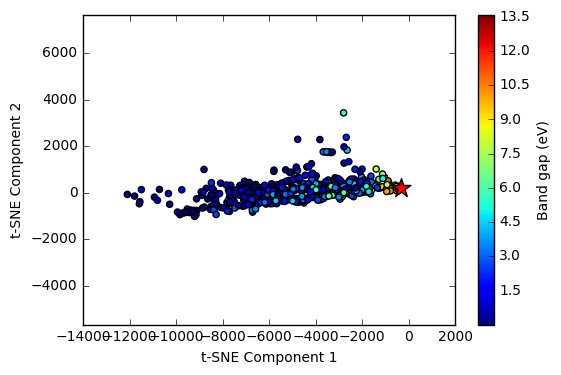

In [8]:
# Get the index of the maximum band gap material
max_bg_index = np.argmax(coordinates_and_bg, axis=0)[2]
print("Maximum band gap material:")
print("{}, Band gap: {}, URL: https://citrination.com/pif/{}"
      .format(tsne["Band gap"]["label"][max_bg_index], 
              tsne["Band gap"]["z"][max_bg_index],
              tsne["Band gap"]["uid"][max_bg_index])
     )
print("Similar materials:")
for idx in find_most_similar_materials(max_bg_index, coordinates_and_bg[:,0:2]):
    print("{}, Band gap: {}, URL: https://citrination.com/pif/{}"
          .format(tsne["Band gap"]["label"][idx],
                  tsne["Band gap"]["z"][idx],
                  tsne["Band gap"]["uid"][idx])
         )

plt.figure()
plt.scatter(tsne["Band gap"]['x'], tsne["Band gap"]['y'], c=tsne["Band gap"]['z'])
plt.colorbar(label="Band gap (eV)")
plt.scatter(coordinates_and_bg[max_bg_index, 0], coordinates_and_bg[max_bg_index, 1],
            marker="*", c="r", s=200)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.axes().set_aspect('equal', 'datalim')
plt.show()

Now let's figure out what material the outlier point with the largest y-value corresponds to

Outlier material (point with the highest y-value):
Single crystalline, C, Band gap: 5.47, URL: https://citrination.com/pif/1160/2/741E3F0149104E500B3433612BE4F15B


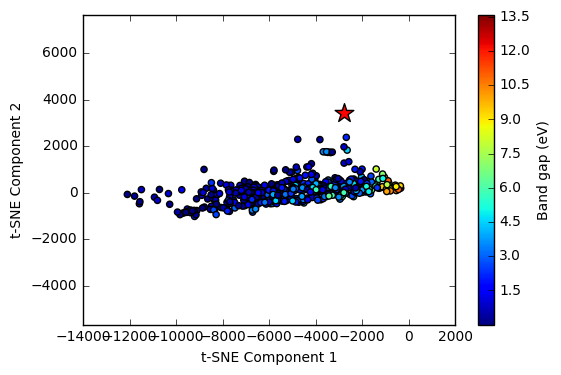

In [9]:
outlier_index = np.argmax(coordinates_and_bg, axis=0)[1]
print("Outlier material (point with the highest y-value):")
print("{}, Band gap: {}, URL: https://citrination.com/pif/{}"
      .format(tsne["Band gap"]["label"][outlier_index],
              tsne["Band gap"]["z"][outlier_index],
              tsne["Band gap"]["uid"][outlier_index])
     )

plt.figure()
plt.scatter(tsne["Band gap"]['x'], tsne["Band gap"]['y'], c=tsne["Band gap"]['z'])
plt.colorbar(label="Band gap (eV)")
plt.scatter(coordinates_and_bg[outlier_index, 0], coordinates_and_bg[outlier_index, 1],
            marker="*", c="r", s=200)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.axes().set_aspect('equal', 'datalim')
plt.show()

We can also find materials that are similar to a given material in the dataset. Let's find materials similar to Cr3Se4 https://citrination.com/datasets/1160/version/2/pif/286ACB115061071F48BB2CEA1768FFFC. The uid comes in the format dataset_id/version/pif_id. For Cr3Se4, the uid is 1160/2/286ACB115061071F48BB2CEA1768FFFC.

Cr3Se4, Band gap: 0.015, URL: https://citrination.com/pif/1160/2/286ACB115061071F48BB2CEA1768FFFC
Similar materials:
Cr2Se3, Band gap: 0.025, URL: https://citrination.com/pif/1160/2/6F239D5016DAE306EC98E60DBCCF1487
Single crystalline, Cd1Sc1, Band gap: 1.714, URL: https://citrination.com/pif/1160/2/2B1AFA22084C46FCF4A59EB8C9C22A5E
Single crystalline, Ti1Te2, Band gap: 1.0, URL: https://citrination.com/pif/1160/2/23D23BB19C9626FB0C013D2A14CFFD1E
Single crystalline, Hf1S2, Band gap: 1.96, URL: https://citrination.com/pif/1160/2/A59973C5B9C1F86F4493728C06E41566
Single crystalline, As, Band gap: 1.2, URL: https://citrination.com/pif/1160/2/82C4942BE74D2C97E3F4F2CA7CBAE350
Single crystalline, Ge1As2, Band gap: 1.0, URL: https://citrination.com/pif/1160/2/CF2F24D75AB9DAEFA4B5637966F36E2F
Polycrystalline, Ge1Te1, Band gap: 0.84, URL: https://citrination.com/pif/1160/2/D91F604B8BFAB589411CBF4A24239FD0
Single crystalline, Ge1As1, Band gap: 0.65, URL: https://citrination.com/pif/1160/2/B1676E8DF

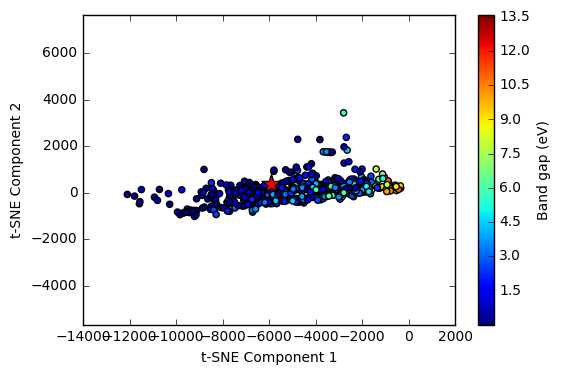

In [10]:
uid = "1160/2/286ACB115061071F48BB2CEA1768FFFC"
cr3se4_index = tsne["Band gap"]["uid"].index(uid)
print("{}, Band gap: {}, URL: https://citrination.com/pif/{}"
      .format(tsne["Band gap"]["label"][cr3se4_index],
              tsne["Band gap"]["z"][cr3se4_index],
              tsne["Band gap"]["uid"][cr3se4_index])
     )
print("Similar materials:")
for idx in find_most_similar_materials(cr3se4_index, coordinates_and_bg[:,0:2]):
    print("{}, Band gap: {}, URL: https://citrination.com/pif/{}"
          .format(tsne["Band gap"]["label"][idx],
                  tsne["Band gap"]["z"][idx],
                  tsne["Band gap"]["uid"][idx])
         )
plt.figure()
plt.scatter(tsne["Band gap"]['x'], tsne["Band gap"]['y'], c=tsne["Band gap"]['z'])
plt.colorbar(label="Band gap (eV)")
plt.scatter(coordinates_and_bg[cr3se4_index, 0], coordinates_and_bg[cr3se4_index, 1],
            marker="*", c="r", s=200)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.axes().set_aspect('equal', 'datalim')
plt.show()

As we've seen here, t-SNE is a useful tool for understanding materials datasets and gaining new insights by visualizing and exploring a large, high-dimensional dataset in two dimensions. In this tutorial, we've seen how to examine outliers, find interesting clusters of similar materials, and find materials that are similar to a given material, which are only some of the cool things that you can do with t-SNE plots. The t-SNE analysis is available for all real-valued outputs specified in the Data Views creation process.